In [1]:
#check if in local or colab
#if in colab run following two cells
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install levenshtein
!pip install git+https://github.com/openai/CLIP.git

In [1]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json
import random
print('import done')

import done


# Path Variable

In [2]:
# import os
# os.chdir('9444')
# this is local path
INPUT_PATH = 'vizwiz'
ANNOTATIONS = os.path.join(INPUT_PATH, 'Annotations')
TRAIN_PATH = os.path.join(INPUT_PATH, 'train')
VALIDATION_PATH = os.path.join(INPUT_PATH, 'val')
ANNOTATIONS_TRAIN_PATH = os.path.join(ANNOTATIONS, 'train.json')
ANNOTATIONS_VAL_PATH = os.path.join(ANNOTATIONS, 'val.json')
OUTPUT_PATH = os.path.join(INPUT_PATH, 'OUTPUT')
RUN_PATH = os.path.join(INPUT_PATH, 'run')
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

#this is colab path
# INPUT_PATH = '/content/drive/MyDrive/9444clip/comp9444'
# ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
# TRAIN_PATH = INPUT_PATH + '/train/train'
# VALIDATION_PATH = INPUT_PATH + '/val/val'
# ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
# ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
# OUTPUT_PATH = '/content/drive/MyDrive/9444clip/OUTPUT/'
# ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
# MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


# Read DF

In [3]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers, answer_type, answerable)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

In [4]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39512


In [5]:
# #generate pkl, only run once to save time.
# clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
# clip_model.eval().requires_grad_(False)

# training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
# training_questions = process_questions(train_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
#     pickle.dump(training_images, f)
# with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
#     pickle.dump(training_questions, f)

# validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
# validation_questions = process_questions(validation_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
#     pickle.dump(validation_images, f)
# with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
#     pickle.dump(validation_questions, f)

# test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
# test_questions = process_questions(test_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
#     pickle.dump(test_images, f)
# with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
#     pickle.dump(test_questions, f)

# VizWiz class

In [6]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, answer_type_onehotencoder = None, answer_onehotencoder = None, model_name = "RN50x64", images_features = torch.tensor([]), questions_features = torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Total counter for all answers before filtering, used in Tie Breaking when building the answer vocabulary
        self.answer_counter = Counter()

        # Saving image & question embeddings
        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()

        # Saving the dataframe
        self.dataframe = dataframe

        # List for answers for each question (each question has 10 answers)
        self.answer_counter_per_question = []

        # Populating the counter for words in answers which will be used when building answer vocabulary
        self.build_answer_counter()

        # Building the answer vocabulary according to the methodology explained in the paper
        self.build_answer_vocab()

        # The number of vocabulary words after filtering
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # One hot encoding the answers
        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])

        # One hot encoding the answer types
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])

        # Saving the one hot encoders
        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        # Transforming the answers and answer types to one hot encoded vectors
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()

        # Saving the answer categories (vocabulary) which will be used when getting index of the predicted answer
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        # Saving answers for each question (each question has 10 answers)
        self.build_answer_counter_per_question()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return self.images_features[index], self.questions_features[index], answer, answer_type, answer_counter, answerable

    def build_answer_counter_per_question(self):

        for index, row in self.dataframe.iterrows():
            temp_list = []
            for answer_map in row['answers']:
                answer = answer_map['answer']
                # check if answer in self.answers_categories
                if answer in self.answers_categories:
                    answer_index = self.answers_categories.index(answer)
                    temp_list.append(answer_index)
            # Torch.tensor requires the all the lists to have constant length, so we pad the list with -1 if needed
            while len(temp_list) < 10:
                temp_list.append(-1)
            self.answer_counter_per_question.append(temp_list)



    def build_answer_vocab(self):
        # Building answer vocab follow this policy:
        # for each question we have 10 answers, we choose the most frequent answer as the answer for this question
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.

        # Copying the original dataframe which will be manipulated
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        # Adding extra column named 'answer'
        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance between the answers in top_elements
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])

    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()

# VQAmodel class

In [18]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name="ViT-L/14@336px", device=torch.device("cpu")):
        super(VQAModel, self).__init__()
        self.training_losses = []
        self.validation_losses = []
        self.training_accuracies = []
        self.validation_accuracies = []
        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []
        self.training_answerability = []
        self.validation_answerability = []
        self.device = device
        self.model_name = model_name

        # Initializing Binary Cross Entropy Loss which will be used to train the model on answerability
        self.answerability_loss_fn = nn.BCELoss()
        # Loading the CLIP model and Freezing the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device=device, download_root=os.path.join('CLIP_checkpoints'))
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # -- Cross-Modality transformer --
        # visual route
        visual_embed_dim = self.clip_model.visual.output_dim
        self.visual_cross_attention = nn.MultiheadAttention(embed_dim=visual_embed_dim, num_heads=2, batch_first=True) # TODO: dropout
        self.visual_self_attention = nn.MultiheadAttention(embed_dim=visual_embed_dim, num_heads=2, batch_first=True)
        self.visual_feed_forward = nn.Sequential(
            nn.Linear(visual_embed_dim, 2 * visual_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * visual_embed_dim, visual_embed_dim)
        )
        self.visual_norm = nn.LayerNorm(visual_embed_dim)
        self.dropout = nn.Dropout(0.2)
        # text route
        text_embed_dim = self.clip_model.text_projection.shape[1]
        self.text_cross_attention = nn.MultiheadAttention(embed_dim=text_embed_dim, num_heads=2, batch_first=True)
        self.text_self_attention = nn.MultiheadAttention(embed_dim=text_embed_dim, num_heads=2, batch_first=True)
        self.text_feed_forward = nn.Sequential(
            nn.Linear(text_embed_dim, 2 * text_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * text_embed_dim, text_embed_dim)
        )
        self.text_norm = nn.LayerNorm(text_embed_dim)
        self.dropout = nn.Dropout(0.2)

        # -- Classification --
        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(text_embed_dim),
            nn.Dropout(p=0.2),
            nn.Linear(text_embed_dim, hidden_size)
        )
        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, num_classes)
        )
        # Answer type and mask layers
        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)
        self.sigmoid = nn.Sigmoid()


        # Answerability Linear Layer
        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim),
            nn.Linear(self.clip_model.visual.output_dim, hidden_size)
        )
        # Answerability Sigmoid Layer
        self.answerability_final_layer = nn.Linear(hidden_size, 1)
        self.answerability_sigmoid = nn.Sigmoid()

    def forward(self, image_features, question_features):
        # Ensure image_features and question_features have the correct dtype
        image_features = image_features.to(torch.float32)
        question_features = question_features.to(torch.float32)
        print("Shape of question_features:", question_features.shape)
        print("Shape of image_features:", image_features.shape)

        # Generate attention masks if necessary
        text_mask = (question_features != 0).all(dim=-1).bool()
        image_mask = (image_features != 0).all(dim=-1).bool()

        # # Adjust mask shapes if needed for MultiheadAttention (e.g., [batch_size, seq_len] -> [seq_len, batch_size])
        # text_mask = text_mask.unsqueeze(1).expand(-1, question_features.size(1), -1)  # Mask shape: (batch_size, text_seq_len)
        # image_mask = image_mask.unsqueeze(1).expand(-1, image_features.size(1), -1)  # Mask shape: (batch_size, image_seq_len)

        # ---- Cross Modality ----
        # Text-to-image cross attention
        text_with_image_context, _ = self.text_cross_attention(
            question_features, image_features, image_features
        )
        question_features = question_features + self.dropout(text_with_image_context)
        question_features = self.text_norm(question_features)

        # Image-to-text cross attention
        image_with_text_context, _ = self.visual_cross_attention(
            image_features, question_features, question_features
        )
        image_features = image_features + self.dropout(image_with_text_context)
        image_features = self.visual_norm(image_features)
        print("Shape of question_features:", question_features.shape)
        print("Shape of image_features:", image_features.shape)

        # Self-attention for text
        text_self_attn_output, _ = self.text_self_attention(
            question_features, question_features, question_features, key_padding_mask=text_mask
        )
        question_features = question_features + self.dropout(text_self_attn_output)
        question_features = self.text_norm(question_features)

        # Self-attention for image
        image_self_attn_output, _ = self.visual_self_attention(
            image_features, image_features, image_features, key_padding_mask=image_mask
        )
        image_features = image_features + self.dropout(image_self_attn_output)
        image_features = self.visual_norm(image_features)
        print("Shape of question_features:", question_features.shape)
        print("Shape of image_features:", image_features.shape)

        # Feed-forward networks
        text_ff_output = self.text_feed_forward(question_features)
        question_features = question_features + self.dropout(text_ff_output)
        question_features = self.text_norm(question_features)

        image_ff_output = self.visual_feed_forward(image_features)
        image_features = image_features + self.dropout(image_ff_output)
        image_features = self.visual_norm(image_features)
        print("Shape of question_features:", question_features.shape)
        print("Shape of image_features:", image_features.shape)
        
        # ---- Classification ----
        # Pass the attended features through the first linear layer
        question_features = question_features.squeeze(1)
        features = self.linear_layer1(question_features)

        # Predict answer type
        answer_type = self.answer_type_layer(features)

        # Generate answer mask and apply sigmoid
        answer_mask = self.answer_mask_layer(answer_type)
        answer_mask = self.sigmoid(answer_mask)

        # Pass through second linear layer for answer prediction
        output = self.linear_layer2(features)
        print('shape of features:', features.shape)
        print('output', output.shape)

        # Apply answer mask
        output = output * answer_mask

        # Calculate answerability score
        answerability_score = self.answerability_linear_layer(question_features)
        answerability_score = self.answerability_final_layer(answerability_score)
        answerability_score = self.answerability_sigmoid(answerability_score).squeeze()

        return output, answer_type, answerability_score


    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        n=2
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy, train_answerability_score = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy, validation_answerability_score = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy, test_answerability_score = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)

            self.training_answerability.append(train_answerability_score)
            self.validation_answerability.append(validation_answerability_score)


            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))
            print("Epoch: {} | Training Answerability Score: {:.3f} | Validation Answerability Score: {:.3f} | Test Answerability Score: {:.3f}\n".format(epoch, train_answerability_score, validation_answerability_score, test_answerability_score))

            if save_path != None and epoch % save_every == 0:
                saved_name = "epoch_{}.pth".format(epoch)
                self.save_model(os.path.join(save_path, saved_name))
        return

    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)
            answerable = 1 - answerable
            answerable_predict = 1.0 - answerable_predict
            
            # answer = answer.long()
            # answer_type = answer_type.long()
            # Convert one-hot encoded targets to class indices
            # answer = answer.argmax(dim=-1).long()  # Shape should be (batch_size, 1)
            # answer_type = answer_type.argmax(dim=-1).long()

            
            # loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
            loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                answerable_true.append(answerable[i].item())
                answerable_predicted.append(answerable_predict[i].item())


        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return training_loss, training_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')


    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)

                # Answerablity is the confidence that quesion is not answerable, so we have to subtract from 1
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                
                # answer = answer.long()
                # answer_type = answer_type.long()
                # answer = answer.argmax(dim=-1).long()  # Shape should be (batch_size, 1)
                # answer_type = answer_type.argmax(dim=-1).long()
            
                # loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
                loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        # We will use weighted average since that there is imbalance in answerability in the dataset as displayed in EDA section
        return validation_loss, validation_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
    def save_model(self, path):
        """
        Saves the model state dictionary to the given path.

        Args:
        - self: the model object
        - path (str): the path to save the model state dictionary

        Returns:
        - None
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Loads the model state dictionary from the given path.

        Args:
        - self: the model object
        - path (str): the path to load the model state dictionary

        Returns:
        - self: the loaded model object
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        """
        Predicts the output and answer type for the given image and question.

        Args:
        - self: the model object
        - image (tensor): the image tensor
        - question (tensor): the question tensor

        Returns:
        - output (tensor): the predicted output tensor
        - answer_type (str): the predicted answer type
        """
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        """
        Plots the training and validation losses.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.figure(figsize=(5, 5))
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.figure(figsize=(5, 5))
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        """
        Plots the VizWiz training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.figure(figsize=(5, 5))
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        """
        Plots the training and validation answerabilities.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.figure(figsize=(5, 5))
        plt.plot(self.training_answerability, label = "Training Answerability")
        plt.plot(self.validation_answerability, label = "Validation Answerability")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        """
        Tests the model by predicting the answer and answer type for the given image and question.

        Args:
        - self: the model object
        - image_path (str): the path to the image file or URL
        - question (str): the question to be asked

        Returns:
        - predicted_answer (tensor): the predicted answer tensor
        - predicted_answer_type (str): the predicted answer type
        """
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        """
        Prints the details of the selected CLIP model.

        Args:
        - self: the model object

        Returns:
        - None
        """
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

    def save_tracking_info(self, path):
        tracking_info_path = os.path.join(path, 'tracking_info.pkl')
        with open(tracking_info_path, "wb") as f:
            tracking_info= {'training_loss': self.training_losses,
                            'validation_loss': self.validation_losses,
                            'training_accuracy': self.training_accuracies,
                            'validation_accuracy': self.validation_accuracies,
            }
            pickle.dump(tracking_info, f)

In [8]:
#load pkl
with open(os. path.join(OUTPUT_PATH, 'training_images.pkl'), 'rb') as f:
    training_images = pickle.load(f)
with open(os. path.join(OUTPUT_PATH, 'training_questions.pkl'), 'rb') as f:
    training_questions = pickle.load(f)
print('done')
with open(os. path.join(OUTPUT_PATH,'validation_images.pkl'), 'rb') as f:
    validation_images = pickle.load(f)
with open(os. path.join(OUTPUT_PATH,'validation_questions.pkl'), 'rb') as f:
    validation_questions = pickle.load(f)
print('done')
with open(os. path.join(OUTPUT_PATH, 'test_images.pkl'), 'rb') as f:
    test_images = pickle.load(f)
with open(os. path.join(OUTPUT_PATH, 'test_questions.pkl'), 'rb') as f:
    test_questions = pickle.load(f)
print('done')

done
done
done


# Dataset loading

In [9]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

# Saving the fitted one hot encoders
with open(os. path.join(OUTPUT_PATH, 'answer_onehotencoder.pkl'), 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(os. path.join(OUTPUT_PATH, 'answer_type_onehotencoder.pkl'), 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5239
Number of distinct answers:  1468
Number of distinct answers:  469


# Training

In [19]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()
#train model
# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 1e-4
NUM_CLASSES = len(training_dataset.get_answer_vocab())
latest_session_num = max([int(d[5:]) for d in os.listdir(RUN_PATH) if d.startswith('train')], default=0)
session_path = os.path.join(RUN_PATH, f'train{latest_session_num + 1}')
os.makedirs(session_path, exist_ok=True)
SAVE_PATH = session_path
SAVE_EVERY = 10

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()
model.save_tracking_info(SAVE_PATH)

Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
shape of features: torch.Size([32, 512])
output torch.Size([32, 5239])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Size([32, 1, 768])
Shape of question_features: torch.Size([32, 1, 768])
Shape of image_features: torch.Siz

ValueError: Input contains NaN.

# Test

In [ ]:
# Load the JSON data
print('start load')
with open("comp9444/Annotations/Annotations/test.json", "r") as file:
    data = json.load(file)
print('load done!')


start load
load done!


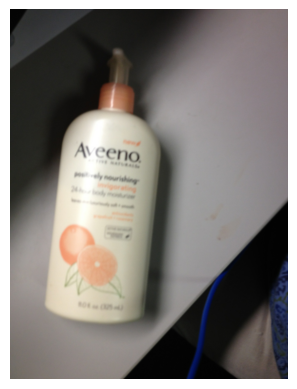

The image id is: VizWiz_test_00006810.jpg
The Question is: What is this?
The Answer is: lotion
The Answer Type is: other
The confidence for being unanswerable: 0.002418994903564453
----------------------------------------


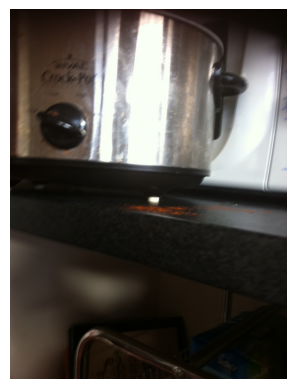

The image id is: VizWiz_test_00007737.jpg
The Question is: Hello there, could you please tell me, going from left to right on this dial, what the temperature range is? 
The Answer is: unsuitable
The Answer Type is: unanswerable
The confidence for being unanswerable: 0.660355806350708
----------------------------------------


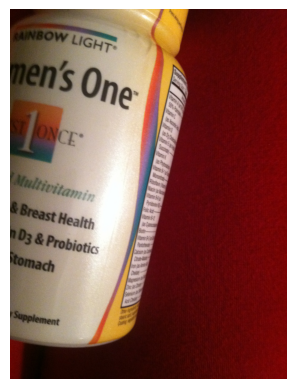

The image id is: VizWiz_test_00005472.jpg
The Question is: What's this bottle?
The Answer is: vitamins
The Answer Type is: other
The confidence for being unanswerable: 0.1989901065826416
----------------------------------------


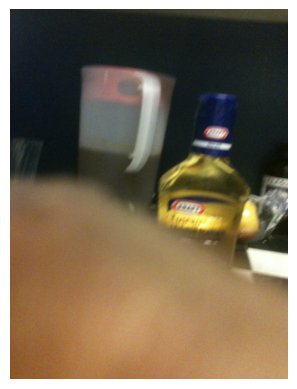

The image id is: VizWiz_test_00000293.jpg
The Question is: What bottle is this please?
The Answer is: unsuitable
The Answer Type is: other
The confidence for being unanswerable: 0.5845637321472168
----------------------------------------


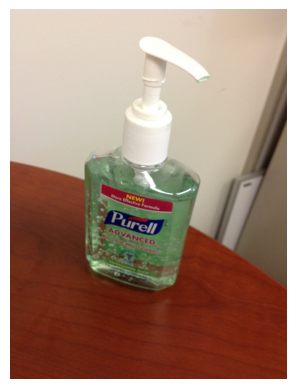

The image id is: VizWiz_test_00001944.jpg
The Question is: What is the meaning of life?
The Answer is: hand sanitizer
The Answer Type is: other
The confidence for being unanswerable: 0.008554577827453613
----------------------------------------


In [ ]:
i = 5

# 随机选择 i 个sample
random_samples = random.sample(data, i)

# 加载 One Hot Encoders

with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

# 加载模型
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
NUM_CLASSES = len(training_dataset.get_answer_vocab())  #调用训练时的同一个vocabulary
MODEL_PATH = OUTPUT_PATH + "comp9444epoch_50.pth"
model = VQAModel(num_classes=NUM_CLASSES, device=DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
#model.load_model(MODEL_PATH)

# 循环测试i个
for sample in random_samples:
    image_url = sample["image"]
    question = sample["question"]
    image_path = "comp9444//test/test/" + image_url

    # 预测答案和答案类型
    predicted_answer, predicted_answer_type, answerability = model.test_model(image_path=image_path, question=question)
    answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
    answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())

    # 显示图像和输出
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    print('The image id is: ' + image_url)
    print("The Question is: " + question)
    print("The Answer is: " + answer[0][0])
    print("The Answer Type is: " + answer_type[0][0])
    print("The confidence for being unanswerable: " + str(answerability.item()))
    print("-" * 40)  # 分隔不同样本的输出

In [ ]:
#build test answer
df = pd.read_json("comp9444/Annotations/Annotations/test.json")
df = df[['image', 'question']]

# let's create two json objects to store the output of the model then write them to a file
model_answers = []
model_answerability = []

for i in range(len(df)):
    image_url = df['image'][i]
    question = df['question'][i]
    image_path = "comp9444/test/test/" + image_url
    predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = image_path, question = question)
    answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
    answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())
    answer_result = {'image': image_url, 'answer': answer[0][0]}
    answerability_result = {'image': image_url, 'answerability': answerability.item()}
    model_answers.append(answer_result)
    model_answerability.append(answerability_result)

# Writing them using pickle
with open('answers_results.json', 'w') as file:
    json.dump(model_answers, file)
with open('answerability_results.json', 'w') as file:
    json.dump(model_answerability, file)